In [1]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from pathlib import Path
from data import SimpleDataset, CellImageDataset
import seaborn as sns
import pandas as pd

In [2]:
imsize = 512
batch_size = 100
# DATA_DIR = Path("./dev-dataset-FUCCI/")
DATA_DIR = Path("/data/ishang/FUCCI-dataset/")
# RGB_DATASET = DATA_DIR / "rgb_native_res_512_min_max.pt"
# dataset = SimpleDataset(path=RGB_DATASET)
# dataset = CellImageDataset(DATA_DIR / "index_rgb_native_res_512_min_max.csv", channel_colors=["pure_blue", "pure_yellow", "pure_green", "pure_red"])
dataset = CellImageDataset(DATA_DIR / "index_native_res_512_min_max.csv", channel_colors=["pure_blue", "pure_yellow", "pure_green", "pure_red"])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)

Loading images: 100%|██████████| 2346/2346 [01:08<00:00, 34.35it/s]


In [3]:
intensities = []
# batch = dataset[:].flatten()
for batch in tqdm(iter(dataloader), desc="Computing intensities"):
    intensities.append(torch.log10(batch[batch > 0].flatten()))
intensities = torch.cat(intensities)
# intensities = batch[batch > 0]
# sns.kdeplot(intensities)
intensities = intensities[torch.randperm(len(intensities))[:10000]]
sns.histplot(intensities, bins=100)
print(intensities.min(), intensities.max())

In [3]:
# print(dataset[:].shape)
# batch = dataset[:, 2:]
# print(batch.shape)
FUCCI_mean_intensities = []
# for batch in iter(datamodule.train_dataloader()):
# batch_size = 100
# for i in range(0, len(dataset), batch_size):
for batch in tqdm(iter(dataloader), desc="Computing mean intensities"):
    # batch = dataset[i:i+batch_size, 2:]
    FUCCI_mean_intensities.append(torch.mean(batch[:, 2:], dim=(2, 3)))
FUCCI_mean_intensities = torch.log10(torch.cat(FUCCI_mean_intensities, dim=0) + 1e-6)


Computing mean intensities: 100%|██████████| 463/463 [02:26<00:00,  3.15it/s]


<Axes: xlabel='GMNN', ylabel='CDT1'>

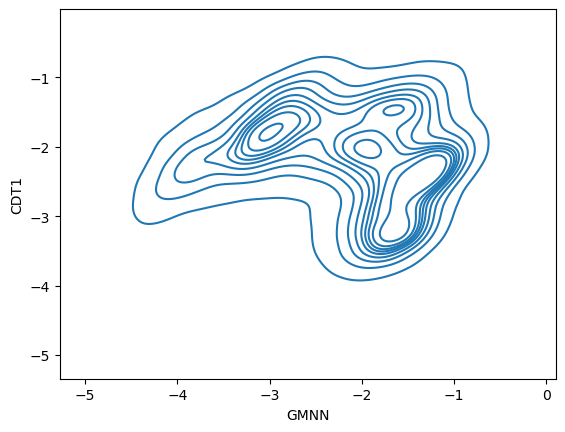

In [4]:

pseudo_time_df = pd.DataFrame(FUCCI_mean_intensities.numpy(), columns=['GMNN', 'CDT1'])
sns.kdeplot(data=pseudo_time_df, x='GMNN', y='CDT1')

<Axes: >

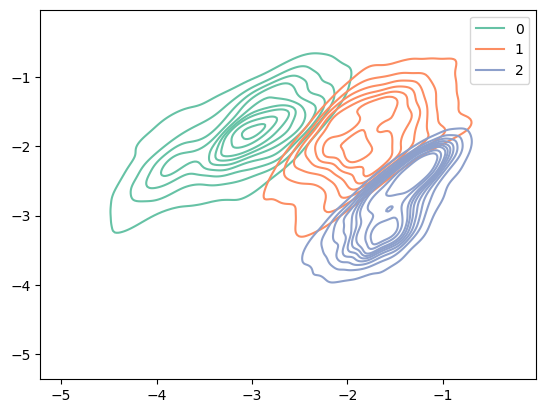

In [12]:
from sklearn import mixture
import numpy as np
indices = torch.randperm(len(FUCCI_mean_intensities))
X_train = FUCCI_mean_intensities[indices[:len(FUCCI_mean_intensities) // 2]]
clf_cc = mixture.GaussianMixture(n_components=3, covariance_type="full", init_params="k-means++")
# clf_cc_log = mixture.GaussianMixture(n_components=3, covariance_type="full", init_params="k-means++")
# clf_batch = mixture.GaussianMixture(n_components=5, covariance_type="full", init_params="k-means++")
log_fn = lambda x: torch.nan_to_num(torch.log(x), neginf=-12)
clf_cc.fit(torch.nan_to_num(X_train, neginf=-12))
# clf_cc_log.fit(log_fn(X_train))
# clf_batch.fit(log_fn(X_train))
X_pred = FUCCI_mean_intensities[indices[len(FUCCI_mean_intensities) // 2:]]
y = clf_cc.predict(X_train)
sns.kdeplot(x=X_train[:, 0], y=X_train[:, 1], hue=clf_cc.predict(X_train), palette="Set2")

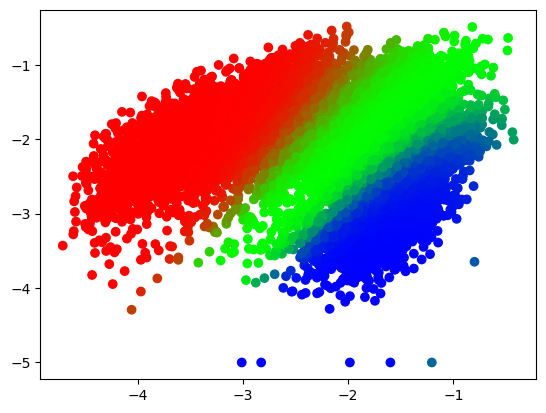

In [18]:
# y = clf_cc.predict(X_pred)
y = clf_cc.predict_proba(X_pred)
# sns.kdeplot(x=X_pred[:, 0], y=X_pred[:, 1], hue=y, palette="Set2")
# sns.histplot(x=X_pred[:1000, 0], y=X_pred[:1000, 1], hue=y[:1000], palette="Set2")
# sns.scatterplot(x=X_pred[:, 0], y=X_pred[:, 1], hue=y[:, 1], palette="Set2")
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
y_PCA = pca.fit_transform(y)
# sns.scatterplot(x=y_PCA[:, 0], y=y_PCA[:, 1])
import matplotlib.pyplot as plt
plt.scatter(X_pred[:10000, 0], X_pred[:10000, 1], c=y[:10000])

In [19]:
import pickle
GMM_FILE = DATA_DIR / "gmm.pkl"
pickle.dump(clf_cc, open(GMM_FILE, "wb"))

<Axes: >

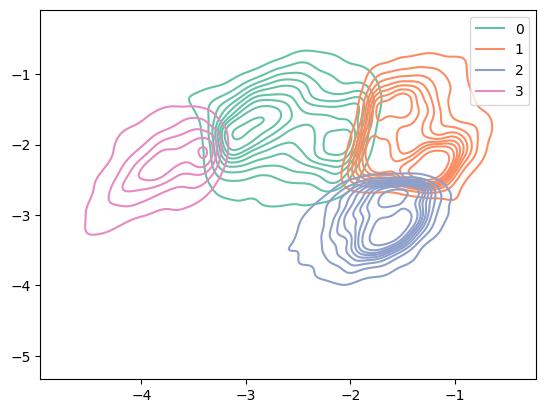

In [10]:
clf_cc = mixture.GaussianMixture(n_components=4, covariance_type="full", init_params="k-means++")
clf_cc.fit(torch.nan_to_num(X_train, neginf=-12))
y = clf_cc.predict(X_train)
sns.kdeplot(x=X_train[:, 0], y=X_train[:, 1], hue=clf_cc.predict(X_train), palette="Set2")

<Axes: >

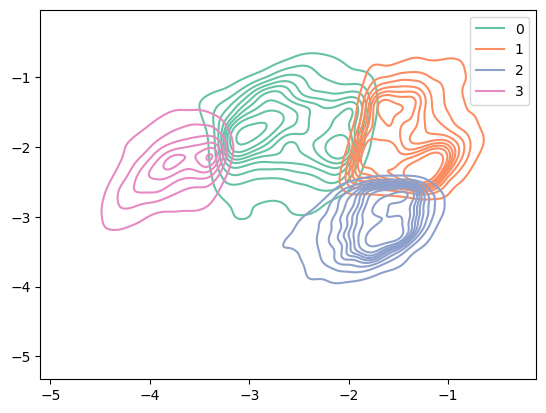

In [11]:
y = clf_cc.predict(X_pred)
sns.kdeplot(x=X_pred[:, 0], y=X_pred[:, 1], hue=y, palette="Set2")

In [ ]:
X_train = FUCCI_mean_intensities[indices[:len(FUCCI_mean_intensities) // 2]]
clf_cc = mixture.GaussianMixture(n_components=3, covariance_type="full", init_params="k-means++")
# clf_cc_log = mixture.GaussianMixture(n_components=3, covariance_type="full", init_params="k-means++")
# clf_batch = mixture.GaussianMixture(n_components=5, covariance_type="full", init_params="k-means++")
log_fn = lambda x: torch.nan_to_num(torch.log(x), neginf=-12)
clf_cc.fit(torch.nan_to_num(X_train, neginf=-12))
# clf_cc_log.fit(log_fn(X_train))
# clf_batch.fit(log_fn(X_train))
X_pred = FUCCI_mean_intensities[indices[len(FUCCI_mean_intensities) // 2:]]
y = clf_cc.predict(X_pred)
sns.kdeplot(x=X_pred[:, 0], y=X_pred[:, 1], hue=y, palette="Set2")

In [ ]:
X_train = FUCCI_mean_intensities[indices[:len(FUCCI_mean_intensities) // 2]]
clf_cc = mixture.GaussianMixture(n_components=4, covariance_type="full", init_params="k-means++")
# clf_cc_log = mixture.GaussianMixture(n_components=3, covariance_type="full", init_params="k-means++")
# clf_batch = mixture.GaussianMixture(n_components=5, covariance_type="full", init_params="k-means++")
log_fn = lambda x: torch.nan_to_num(torch.log(x), neginf=-12)
clf_cc.fit(torch.nan_to_num(X_train, neginf=-12))
# clf_cc_log.fit(log_fn(X_train))
# clf_batch.fit(log_fn(X_train))
X_pred = FUCCI_mean_intensities[indices[len(FUCCI_mean_intensities) // 2:]]
y = clf_cc.predict(X_pred)
sns.kdeplot(x=X_pred[:, 0], y=X_pred[:, 1], hue=y, palette="Set2")

In [ ]:
X_train = FUCCI_mean_intensities[indices[:len(FUCCI_mean_intensities) // 2]]
clf_cc = mixture.GaussianMixture(n_components=5, covariance_type="full", init_params="k-means++")
# clf_cc_log = mixture.GaussianMixture(n_components=3, covariance_type="full", init_params="k-means++")
# clf_batch = mixture.GaussianMixture(n_components=5, covariance_type="full", init_params="k-means++")
log_fn = lambda x: torch.nan_to_num(torch.log(x), neginf=-12)
clf_cc.fit(torch.nan_to_num(X_train, neginf=-12))
# clf_cc_log.fit(log_fn(X_train))
# clf_batch.fit(log_fn(X_train))
X_pred = FUCCI_mean_intensities[indices[len(FUCCI_mean_intensities) // 2:]]
y = clf_cc.predict(X_pred)
sns.kdeplot(x=X_pred[:, 0], y=X_pred[:, 1], hue=y, palette="Set2")

In [ ]:
sns.scatterplot(data=pseudo_time_df, x='GMNN', y='CDT1')

In [ ]:
FUCCI_log_intensities = []
# for batch in iter(datamodule.train_dataloader()):
batch = torch.log(batch + 1) # batch is unnormalized
FUCCI_log_intensities.append(torch.mean(batch, dim=(2, 3)))
FUCCI_log_intensities = torch.cat(FUCCI_log_intensities, dim=0)
pseudo_time_df = pd.DataFrame(FUCCI_log_intensities.numpy(), columns=['GMNN', 'CDT1'])
sns.kdeplot(data=pseudo_time_df, x='GMNN', y='CDT1')

In [ ]:
print(torch.isinf(torch.log(FUCCI_log_intensities + 1e-10)).any())
pseudo_time_df = pd.DataFrame(torch.log(FUCCI_log_intensities + 1e-10).numpy(), columns=['GMNN', 'CDT1'])
sns.kdeplot(data=pseudo_time_df, x='GMNN', y='CDT1')

In [ ]:
FUCCI_intensities, FUCCI_intensities_norm = [], []
FUCCI_mins, FUCCI_maxes = [], []
for batch in iter(datamodule.train_dataloader()):
    flattened = batch.flatten(start_dim=2)
    mins = torch.min(torch.min(flattened, dim=2).values, dim=0, keepdim=True).values
    maxes = torch.max(torch.max(flattened, dim=2).values, dim=0, keepdim=True).values
    intensities = torch.sum(batch, dim=(2, 3))
    intensities_norm = (intensities - mins) / (maxes - mins + 1e-6)
    FUCCI_intensities.append(intensities)
    FUCCI_intensities_norm.append(intensities_norm)
    FUCCI_mins.append(mins)
    FUCCI_maxes.append(maxes)
FUCCI_intensities = torch.cat(FUCCI_intensities, dim=0)
FUCCI_intensities_norm = torch.cat(FUCCI_intensities_norm, dim=0)
FUCCI_mins = torch.cat(FUCCI_mins, dim=0)
FUCCI_maxes = torch.cat(FUCCI_maxes, dim=0)
print(FUCCI_intensities.shape)

In [ ]:
sns.histplot(FUCCI_mins[:, 0])
sns.histplot(FUCCI_mins[:, 1])

In [ ]:
sns.histplot(FUCCI_maxes[:, 0])
sns.histplot(FUCCI_maxes[:, 1])

In [ ]:
# plot the intensities as a scatter plot
fucci_df = pd.DataFrame(np.log10(FUCCI_intensities.numpy() + 1e-6), columns=['GMNN', 'CDT1'])
sns.kdeplot(data=fucci_df, x='GMNN', y='CDT1')

In [ ]:
fucci_df_norm = pd.DataFrame(np.log10(FUCCI_intensities_norm.numpy() + 1e-6), columns=['GMNN', 'CDT1'])
sns.kdeplot(data=fucci_df_norm, x='GMNN', y='CDT1')

In [ ]:
fucci_df_norm = pd.DataFrame(np.log10(FUCCI_intensities_norm.numpy()), columns=['GMNN', 'CDT1'])
sns.kdeplot(data=fucci_df_norm, x='GMNN', y='CDT1')

In [ ]:
from sklearn import mixture
indices = torch.randperm(len(FUCCI_intensities_norm))
X_train = FUCCI_intensities_norm[indices[:len(FUCCI_intensities_norm) // 2]]
print(X_train.shape)
clf_cc = mixture.GaussianMixture(n_components=3, covariance_type="full", init_params="k-means++")
clf_cc_log = mixture.GaussianMixture(n_components=3, covariance_type="full", init_params="k-means++")
clf_batch = mixture.GaussianMixture(n_components=5, covariance_type="full", init_params="k-means++")
print(torch.isinf(torch.log(X_train)).sum())
print(torch.isinf(torch.nan_to_num(torch.log(X_train), neginf=-4).sum()))
log_fn = lambda x: torch.nan_to_num(torch.log(x), neginf=-4)
clf_cc.fit(X_train)
clf_cc_log.fit(log_fn(X_train))
clf_batch.fit(log_fn(X_train))
sns.kdeplot(x=np.log(X_train[:, 0]), y=np.log(X_train[:, 1]))

In [ ]:
X_pred = FUCCI_intensities_norm[indices[len(FUCCI_intensities_norm) // 2:]]
y = clf_cc.predict(X_pred)
sns.kdeplot(x=np.log(X_pred[:, 0]), y=np.log(X_pred[:, 1]), hue=y, palette="Set2")

In [ ]:
X_pred = FUCCI_intensities_norm[indices[len(FUCCI_intensities_norm) // 2:]]
y = clf_cc_log.predict(log_fn(X_pred))
sns.kdeplot(x=np.log(X_pred[:, 0]), y=np.log(X_pred[:, 1]), hue=y, palette="Set2")
# gmm_df = pd.DataFrame(np.log10(X_pred), columns=["GMNN", "CDT1"])
# gmm_df['label'] = y
# sns.scatterplot(data=gmm_df, x="GMNN", y="CDT1", hue="label", palette="Set2")
# sns.kdeplot(data=gmm_df, x="GMNN", y="CDT1")

In [ ]:
y = clf_batch.predict(log_fn(X_pred))
sns.kdeplot(x=np.log(X_pred[:, 0]), y=np.log(X_pred[:, 1]), hue=y, palette="Set2")